第十一章 训练深度神经网络

一、训练难度

1、梯度消失或梯度爆炸，使低层的神经网络很难训练

2、训练速度很慢

3、面临过度拟合的风险



In [2]:
import os
os.environ['OMP_NUM_THREADS']="7"
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

二、梯度消失/梯度爆炸

1、梯度消失：在反向求解梯度时，梯度越来越小，趋近于0，导致算法无法收敛到一个很好的解

2、梯度爆炸：有些梯度趋近于无穷，导致算法发散

3、解决办法1：合理初始化神经网络与神经网络之间的权重

4、解决办法2：非饱和激活函数

推荐的饱和激活函数的使用顺序：ELU(α=1)>leaky ReLU(α=0.01)>ReLU>tanh>logistic

其他选择：RReLU（随机选取α）可以避免过拟合的风险

PReLU(可以训练参数α)，但是需要大量的数据

5、解决办法3：BN(batch normalization)

6、解决办法4：Gradient Clipping(缓解梯度爆炸问题)

In [23]:
#处理数据
def preprocess_data(x_train,x_test):
    x_train=x_train/255.0
    x_test=x_test/255.0
    return x_train,x_test
mnist=tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train,x_test=preprocess_data(x_train,x_test)

初始化权重的常用方法
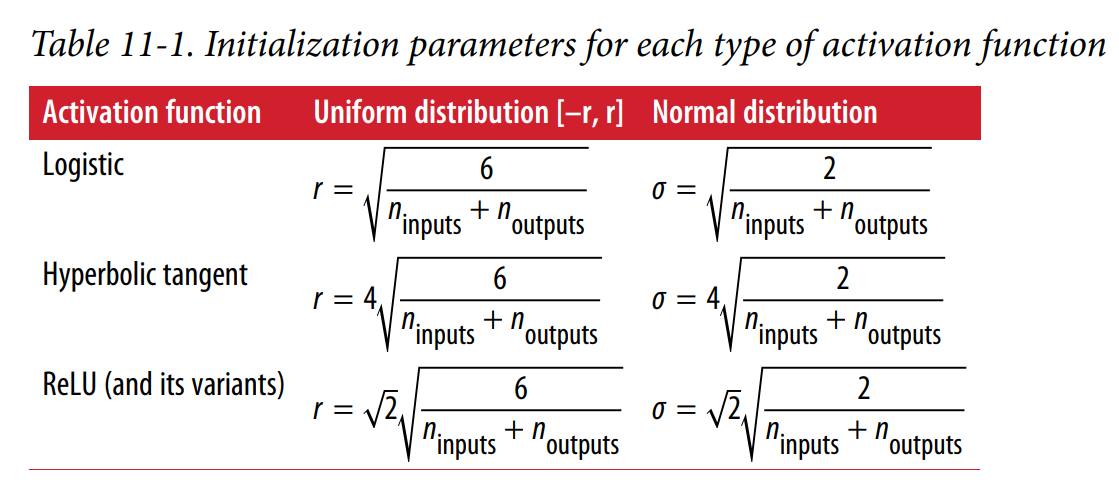

In [24]:
#初始化权重示例
he_init=tf.keras.initializers.VarianceScaling(scale=2,mode="fan_avg",
                                              distribution="uniform")
hidden1=tf.keras.layers.Dense(300,activation="relu",
                              kernel_initializer=he_init,
                              name="hidden1")(x_train)
#不同的激活函数
#relu:2
#tanh/sigmoid:1/3
#mode可选"fan_in"/"fan_avg"/"fan_out"(分别对应使用输入单元、平均值和输出单元来计算方差)



In [25]:
#选择非饱和激活函数的示例
def leaky_relu(z,name=None):
    return tf.maximum(0.01*z,z,name=name)
hidden1=tf.keras.layers.Dense(100,activation=leaky_relu,name="hidden1")(x_train)

In [26]:
#使用batchnormalization的示例
#定义模型
model=tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10,activation="sigmoid"),
])
#编译模型
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
#模型拟合
model.fit(x_train,y_train,batch_size=5000,epochs=10)
model.evaluate(x_test,y_test)
y_pred=np.argmax(model.predict(x_test),axis=1).reshape(-1,1)[9]
print(y_pred,y_test[9:10])

Epoch 1/10


c:\Users\youyiting\anaconda3\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5342 - loss: 1.5074
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9016 - loss: 0.3380
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9300 - loss: 0.2391
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9479 - loss: 0.1843
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9580 - loss: 0.1544
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9636 - loss: 0.1330
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9694 - loss: 0.1143
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9745 - loss: 0.0960
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9794 - loss: 0.0828
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9825 - loss: 0.0733
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.8433 - loss: 0.5500
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[9] [9]


In [27]:
#使用梯度裁剪的示例
#定义模型
model=tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300,activation="relu",name="hidden1"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100,activation="relu",name="hidden2"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10,activation="sigmoid"),
])
#定义优化器，并设置梯度裁剪
optimizer=tf.keras.optimizers.Adam(clipvalue=1.0)
#编译模型
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
#模型拟合
model.fit(x_train,y_train,batch_size=500,epochs=100)
model_evaluate=model.evaluate(x_test,y_test)
y_pred=np.argmax(model.predict(x_test),axis=1).reshape(-1,1)[9]
print(y_pred,y_test[9:10])
print(model_evaluate)

Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8173 - loss: 0.6098
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9689 - loss: 0.1143
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9822 - loss: 0.0652
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9905 - loss: 0.0391
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9949 - loss: 0.0241
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9976 - loss: 0.0135
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9988 - loss: 0.0092
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9987 - loss: 0.0077
Epoch 9/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9989 - loss: 0.0060
Epoch 10/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9996 - loss: 0.0039
Epoch 11/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9996 - loss: 0.0031
Epoch 12/100
120/120 ━━━━━━━━━━━━━━━━━━━━

In [28]:
folder_path="D:\机器学习"
os.makedirs(folder_path,exist_ok=True)
#保存模型
model.save(os.path.join(folder_path,"model_2024_6_22.keras"))

三、重新使用预训练层（可以加快训练速度）

1、重新使用训练好的神经网络模型（Tensorflow或其他框架的神经网络模型均可）

2、冻结低层的神经网络

3、缓存冻结的图层（将冻结图层的输出作为更高层神经网络的输入加快模型训练）

4、调整、删除、替换上层

5、从“model zoo”中筛选可以完成相似任务的深度学习模型

6、无监督预训练（当带标签的数据不够多时）

7、辅助任务的预训练

调用在mnist训练过的神经网络中的隐藏层搭建新的神经网络并用于fashion_mnist

的图像识别

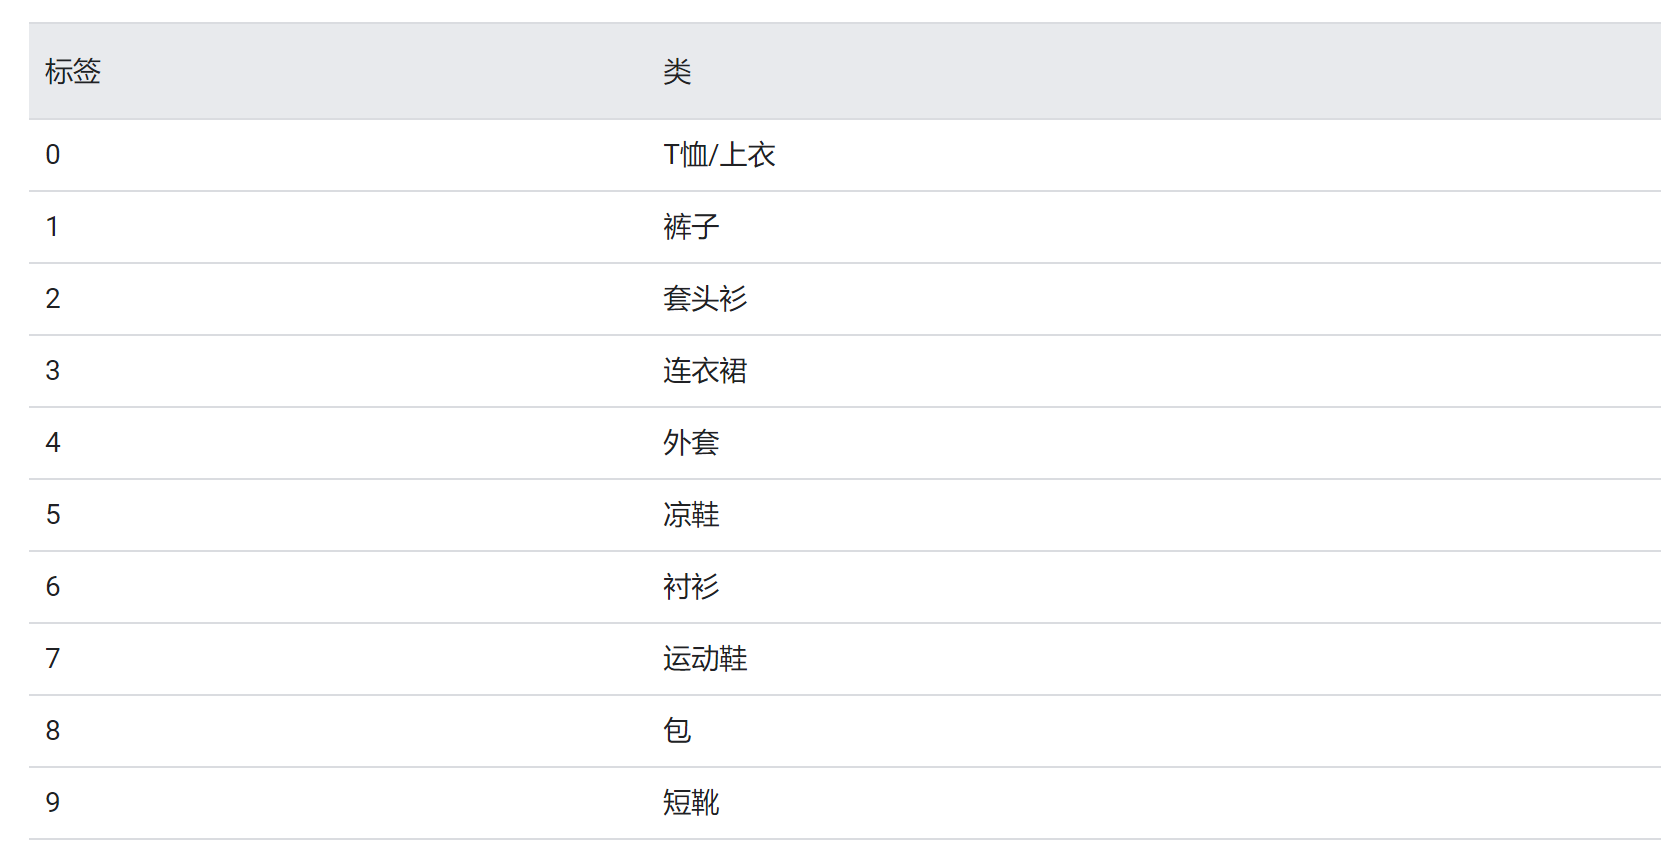

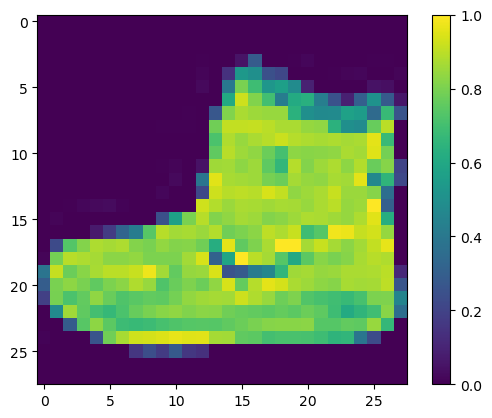

In [3]:
#预处理数据
fashion_mnist=tf.keras.datasets.fashion_mnist
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()
train_images=train_images/255.0
test_images=test_images/255.0
#可视化
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

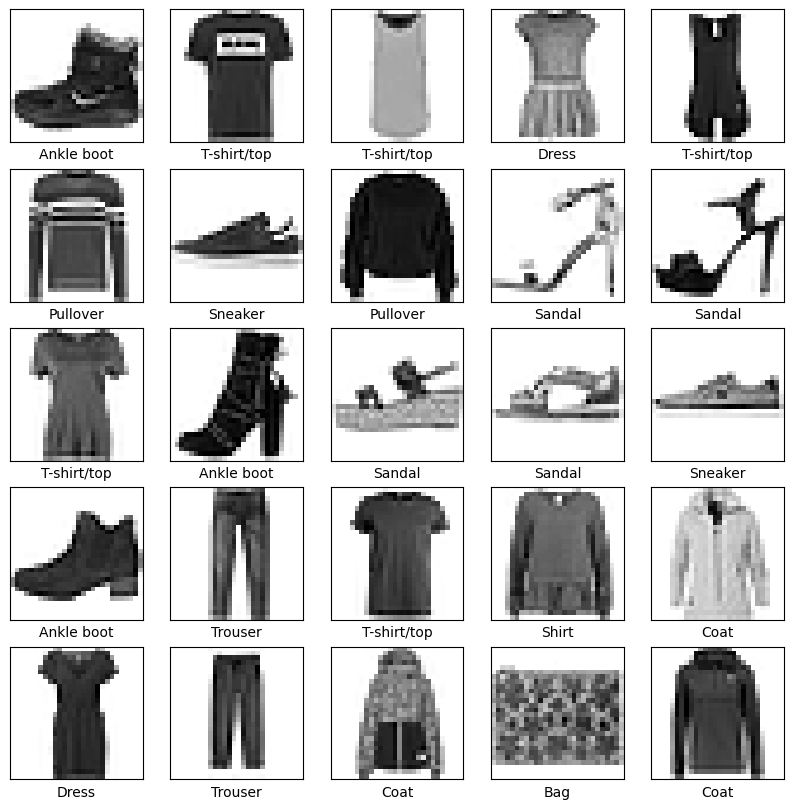

In [30]:
plt.figure(figsize=(10,10))
class_names=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i],cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [31]:
#加载数据
fashion_mnist=tf.keras.datasets.fashion_mnist
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()
train_images=train_images/255.0
test_images=test_images/255.0
#定义模型
old_model=tf.keras.models.load_model("model_2024_6_22.keras")
hidden1=old_model.get_layer("hidden1")
hidden2=old_model.get_layer("hidden2")
new_model=tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    hidden1,
    hidden2,
    tf.keras.layers.Dense(10,activation="sigmoid")
])
#编译模型
new_model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
#模型拟合
new_model.fit(train_images,train_labels,batch_size=500,epochs=20)
model_evaluate=new_model.evaluate(test_images,test_labels)
predictions=new_model.predict(test_images)
y_pred=np.argmax(new_model.predict(test_images),axis=1)[9:10]
print(y_pred,test_labels[9:10])
print(predictions)

Epoch 1/20


c:\Users\youyiting\anaconda3\lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6496 - loss: 1.0643
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8539 - loss: 0.4117
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8752 - loss: 0.3535
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8852 - loss: 0.3194
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8917 - loss: 0.2987
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8976 - loss: 0.2807
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9048 - loss: 0.2647
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9077 - loss: 0.2536
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9132 - loss: 0.2411
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9141 - loss: 0.2337
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9212 - loss: 0.2214
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy

In [32]:
#可视化最终的结果
def plot_image(i,predictions_array,true_label,img):
    true_label,img=true_label[i],img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img,cmap=plt.cm.binary)

    predicted_label=np.argmax(predictions_array)
    if predicted_label==true_label:
        color='blue'
    else:
        color="red"
    plt.xlabel("{}{:2.0f}%({})".format(class_names[predicted_label],
                                       100*np.max(predictions_array),
                                       class_names[true_label],
                                       color=color))
def plot_value_array(i,predictions_array,true_label):
    true_label=true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot=plt.bar(range(10),predictions_array,color="#777777")
    plt.ylim([0,1])
    predicted_label=np.argmax(predictions_array)
    thisplot[predicted_label].set_color("red")
    thisplot[true_label].set_color("blue")

    

0.32415440678596497


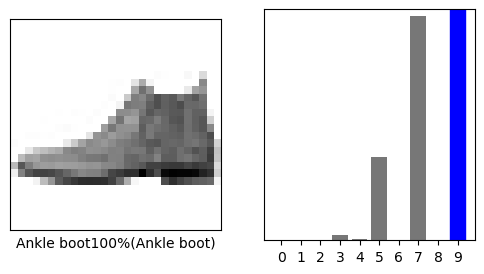

In [33]:
i=0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i,predictions[i],test_labels,test_images)
plt.subplot(1,2,2)
plot_value_array(i,predictions[i],test_labels)
print(model_evaluate[i])

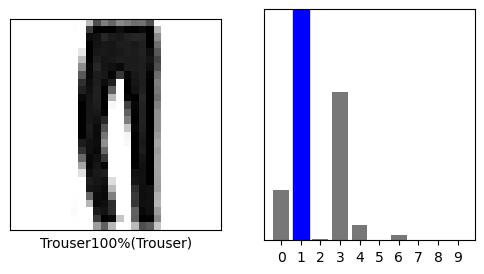

In [34]:
i=2
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i,predictions[i],test_labels,test_images)
plt.subplot(1,2,2)
plot_value_array(i,predictions[i],test_labels)

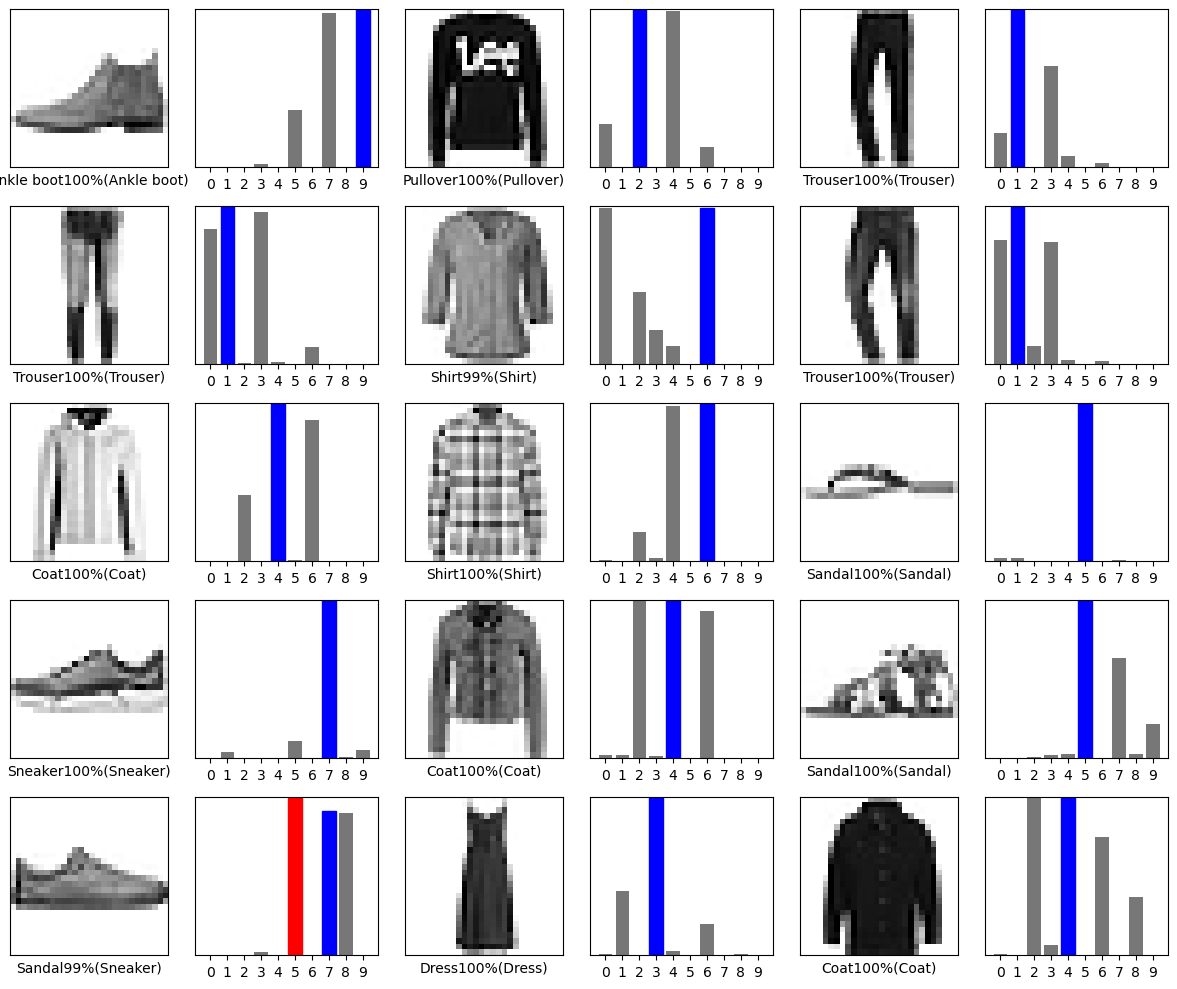

In [35]:
#绘制前几个的结果
num_rows=5
num_cols=3
num_images=num_rows*num_cols
plt.figure(figsize=(2*2*num_cols,2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows,2*num_cols,2*i+1)
    plot_image(i,predictions[i],test_labels,test_images)
    plt.subplot(num_rows,2*num_cols,2*i+2)
    plot_value_array(i,predictions[i],test_labels)
plt.tight_layout()
plt.show()

重新使用低层的神经网络，并且冻结训练

In [55]:
#冻结底层神经网络的示例
#导入数据
from tensorflow.keras.layers import Layer
fashion_mnist=tf.keras.datasets.fashion_mnist
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()
train_images=train_images/255.0
test_images=test_images/255.0
class StopGradientLayer(Layer):
    def __init__(self, **kwargs):
        super(StopGradientLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.stop_gradient(inputs)
#定义模型
old_model=tf.keras.models.load_model("model_2024_6_22.keras")
hidden1=old_model.get_layer("hidden1")
hidden2=old_model.get_layer("hidden2")
inputs=tf.keras.Input(shape=(28,28,1))
x=tf.keras.layers.Flatten()(inputs)
x=tf.keras.layers.BatchNormalization()(x)
x=hidden1(x)
x=tf.keras.layers.BatchNormalization()(x)
x=hidden2(x)
stop_gradient=StopGradientLayer()(x)
#x=tf.keras.layers.BatchNormalization()(x)
#hidden3=tf.keras.layers.Dense(50,activation="relu")
x=tf.keras.layers.BatchNormalization()(x)
outputs=tf.keras.layers.Dense(10,activation="sigmoid")(x)
model_copy=tf.keras.Model(
    inputs=inputs,
    outputs=outputs)
#冻结hidden1和hidden2的权重
for layer in [hidden1,hidden2]:
    layer.trainable=False
model_copy.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model_copy.fit(train_images,train_labels,batch_size=500,epochs=20)
result=model_copy.evaluate(test_images,test_labels)
print(result)


Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2905 - loss: 2.1750
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6989 - loss: 0.8673
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7452 - loss: 0.7122
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7674 - loss: 0.6432
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7817 - loss: 0.6040
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7896 - loss: 0.5728
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7977 - loss: 0.5515
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8041 - loss: 0.5379
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8105 - loss: 0.5174
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8141 - loss: 0.5126
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8213 - loss: 0.4947
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

四、更快的优化器

1、Momentum Optimization

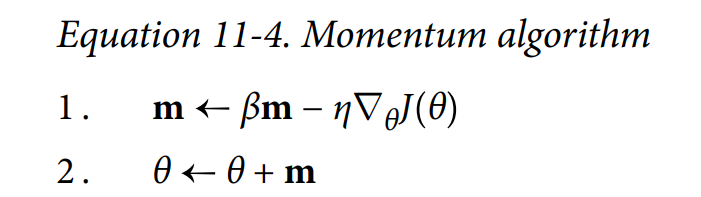

（超参数β常设为0.9）

2、Nesterov Accelerated Gradient

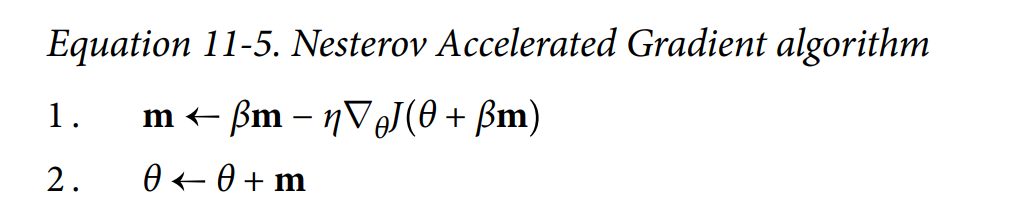

3、AdaGrad(不建议用来训练深度神经网络，未收敛到全局最优解时，梯度下降就会彻底停止)

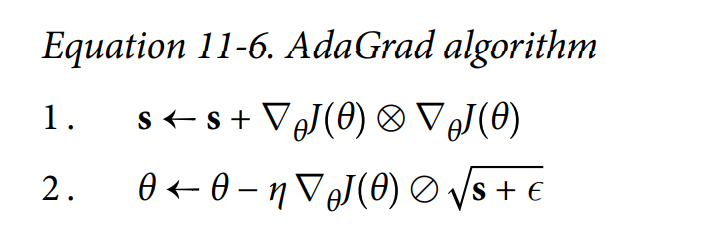

4、RMSProp

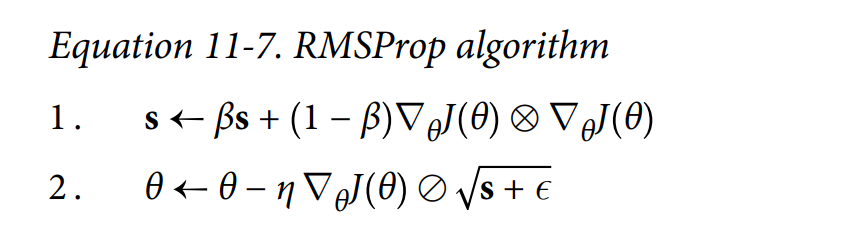

5、Adam(正确率最高、训练速度最快，首选！)

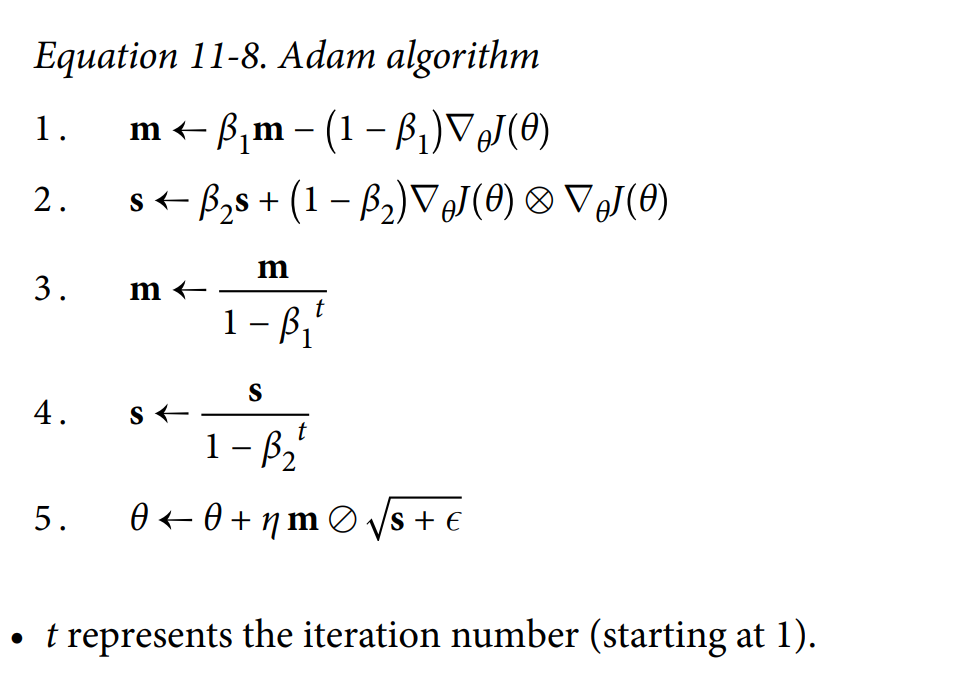

In [57]:
#选用动量优化器的应用示例
from tensorflow.keras.layers import Layer
fashion_mnist=tf.keras.datasets.fashion_mnist
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()
train_images=train_images/255.0
test_images=test_images/255.0
class StopGradientLayer(Layer):
    def __init__(self, **kwargs):
        super(StopGradientLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.stop_gradient(inputs)
#定义模型
old_model=tf.keras.models.load_model("model_2024_6_22.keras")
hidden1=old_model.get_layer("hidden1")
hidden2=old_model.get_layer("hidden2")
inputs=tf.keras.Input(shape=(28,28,1))
x=tf.keras.layers.Flatten()(inputs)
x=tf.keras.layers.BatchNormalization()(x)
x=hidden1(x)
x=tf.keras.layers.BatchNormalization()(x)
x=hidden2(x)
stop_gradient=StopGradientLayer()(x)
#x=tf.keras.layers.BatchNormalization()(x)
#hidden3=tf.keras.layers.Dense(50,activation="relu")
x=tf.keras.layers.BatchNormalization()(x)
outputs=tf.keras.layers.Dense(10,activation="sigmoid")(x)
model_copy=tf.keras.Model(
    inputs=inputs,
    outputs=outputs)
#冻结hidden1和hidden2的权重
for layer in [hidden1,hidden2]:
    layer.trainable=False
#编译模型
optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9)
model_copy.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model_copy.fit(train_images,train_labels,batch_size=500,epochs=20)
result=model_copy.evaluate(test_images,test_labels)
print(result)


Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4761 - loss: 1.6279
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7387 - loss: 0.7267
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7615 - loss: 0.6628
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7647 - loss: 0.6417
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7740 - loss: 0.6201
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7814 - loss: 0.6014
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7853 - loss: 0.5877
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7881 - loss: 0.5792
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7920 - loss: 0.5690
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7972 - loss: 0.5590
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7998 - loss: 0.5498
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

In [58]:
#选用nesterov动量优化器的应用示例
from tensorflow.keras.layers import Layer
fashion_mnist=tf.keras.datasets.fashion_mnist
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()
train_images=train_images/255.0
test_images=test_images/255.0
class StopGradientLayer(Layer):
    def __init__(self, **kwargs):
        super(StopGradientLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.stop_gradient(inputs)
#定义模型
old_model=tf.keras.models.load_model("model_2024_6_22.keras")
hidden1=old_model.get_layer("hidden1")
hidden2=old_model.get_layer("hidden2")
inputs=tf.keras.Input(shape=(28,28,1))
x=tf.keras.layers.Flatten()(inputs)
x=tf.keras.layers.BatchNormalization()(x)
x=hidden1(x)
x=tf.keras.layers.BatchNormalization()(x)
x=hidden2(x)
stop_gradient=StopGradientLayer()(x)
#x=tf.keras.layers.BatchNormalization()(x)
#hidden3=tf.keras.layers.Dense(50,activation="relu")
x=tf.keras.layers.BatchNormalization()(x)
outputs=tf.keras.layers.Dense(10,activation="sigmoid")(x)
model_copy=tf.keras.Model(
    inputs=inputs,
    outputs=outputs)
#冻结hidden1和hidden2的权重
for layer in [hidden1,hidden2]:
    layer.trainable=False
#编译模型
optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,nesterov=True)
model_copy.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model_copy.fit(train_images,train_labels,batch_size=500,epochs=20)
result=model_copy.evaluate(test_images,test_labels)
print(result)

Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4883 - loss: 1.4972
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7363 - loss: 0.7289
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7578 - loss: 0.6694
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7705 - loss: 0.6317
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7776 - loss: 0.6135
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7807 - loss: 0.5935
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7860 - loss: 0.5841
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7872 - loss: 0.5758
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7931 - loss: 0.5657
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7963 - loss: 0.5577
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7966 - loss: 0.5575
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

In [59]:
#使用RMSProp优化器示例
from tensorflow.keras.layers import Layer
fashion_mnist=tf.keras.datasets.fashion_mnist
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()
train_images=train_images/255.0
test_images=test_images/255.0
class StopGradientLayer(Layer):
    def __init__(self, **kwargs):
        super(StopGradientLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.stop_gradient(inputs)
#定义模型
old_model=tf.keras.models.load_model("model_2024_6_22.keras")
hidden1=old_model.get_layer("hidden1")
hidden2=old_model.get_layer("hidden2")
inputs=tf.keras.Input(shape=(28,28,1))
x=tf.keras.layers.Flatten()(inputs)
x=tf.keras.layers.BatchNormalization()(x)
x=hidden1(x)
x=tf.keras.layers.BatchNormalization()(x)
x=hidden2(x)
stop_gradient=StopGradientLayer()(x)
#x=tf.keras.layers.BatchNormalization()(x)
#hidden3=tf.keras.layers.Dense(50,activation="relu")
x=tf.keras.layers.BatchNormalization()(x)
outputs=tf.keras.layers.Dense(10,activation="sigmoid")(x)
model_copy=tf.keras.Model(
    inputs=inputs,
    outputs=outputs)
#冻结hidden1和hidden2的权重
for layer in [hidden1,hidden2]:
    layer.trainable=False
#编译模型
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.01,
    momentum=0.9,
    rho=0.9,  # 在 tf.keras 中，RMSProp 的 decay 参数被称为 rho
    epsilon=1e-10
)
model_copy.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model_copy.fit(train_images,train_labels,batch_size=500,epochs=20)
result=model_copy.evaluate(test_images,test_labels)
print(result)


Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6945 - loss: 0.9213
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8376 - loss: 0.4513
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8362 - loss: 0.4582
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8431 - loss: 0.4332
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8481 - loss: 0.4213
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8492 - loss: 0.4187
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8485 - loss: 0.4219
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8484 - loss: 0.4171
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8505 - loss: 0.4141
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8545 - loss: 0.4090
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8557 - loss: 0.3988
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

In [4]:
#使用Adam优化器示例
from tensorflow.keras.layers import Layer
fashion_mnist=tf.keras.datasets.fashion_mnist
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()
train_images=train_images/255.0
test_images=test_images/255.0
class StopGradientLayer(Layer):
    def __init__(self, **kwargs):
        super(StopGradientLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.stop_gradient(inputs)
#定义模型
old_model=tf.keras.models.load_model("model_2024_6_22.keras")
hidden1=old_model.get_layer("hidden1")
hidden2=old_model.get_layer("hidden2")
inputs=tf.keras.Input(shape=(28,28,1))
x=tf.keras.layers.Flatten()(inputs)
x=tf.keras.layers.BatchNormalization()(x)
x=hidden1(x)
x=tf.keras.layers.BatchNormalization()(x)
x=hidden2(x)
stop_gradient=StopGradientLayer()(x)
#x=tf.keras.layers.BatchNormalization()(x)
#hidden3=tf.keras.layers.Dense(50,activation="relu")
x=tf.keras.layers.BatchNormalization()(x)
outputs=tf.keras.layers.Dense(10,activation="sigmoid")(x)
model_copy=tf.keras.Model(
    inputs=inputs,
    outputs=outputs)
#冻结hidden1和hidden2的权重
for layer in [hidden1,hidden2]:
    layer.trainable=False
#编译模型
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01)
model_copy.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model_copy.fit(train_images,train_labels,batch_size=500,epochs=20)
result=model_copy.evaluate(test_images,test_labels)
print(result)


Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6477 - loss: 0.9921
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8141 - loss: 0.5066
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8347 - loss: 0.4576
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8437 - loss: 0.4339
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8500 - loss: 0.4146
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8559 - loss: 0.3953
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8561 - loss: 0.3950
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8627 - loss: 0.3767
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8611 - loss: 0.3816
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8675 - loss: 0.3647
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8684 - loss: 0.3611
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

五、调整学习率

1、Predetermined piecewise constant learning rate

2、Performance scheduling

3、Exponential scheduling

4、Power scheduling

In [18]:
#定义模型
old_model=tf.keras.models.load_model("model_2024_6_22.keras")
hidden1=old_model.get_layer("hidden1")
hidden2=old_model.get_layer("hidden2")
inputs=tf.keras.Input(shape=(28,28,1))
x=tf.keras.layers.Flatten()(inputs)
x=tf.keras.layers.BatchNormalization()(x)
x=hidden1(x)
x=tf.keras.layers.BatchNormalization()(x)
x=hidden2(x)
stop_gradient=StopGradientLayer()(x)
#x=tf.keras.layers.BatchNormalization()(x)
#hidden3=tf.keras.layers.Dense(50,activation="relu")
x=tf.keras.layers.BatchNormalization()(x)
outputs=tf.keras.layers.Dense(10,activation="sigmoid")(x)
model_copy=tf.keras.Model(
    inputs=inputs,
    outputs=outputs)
#冻结hidden1和hidden2的权重
for layer in [hidden1,hidden2]:
    layer.trainable=False

#以指数式衰减调整学习率为例
initial_learning_rate=0.1#设置初始化学习率
decay_steps=1000#设置衰减步骤
decay_rate=1/10#控制衰减速率

#建立学习率衰减函数
lr_schedule=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

#设置优化器
optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9)
#配置模型
model_copy.compile(optimizer=optimizer,
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])
#训练并评价模型
model_copy.fit(train_images,train_labels,batch_size=500,epochs=20)
result=model_copy.evaluate(test_images,test_labels)
print(result)


Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6453 - loss: 1.0401
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7929 - loss: 0.5649
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8039 - loss: 0.5398
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8145 - loss: 0.5092
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8182 - loss: 0.4986
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8225 - loss: 0.4857
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8304 - loss: 0.4663
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8301 - loss: 0.4657
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8322 - loss: 0.4556
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8418 - loss: 0.4345
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8402 - loss: 0.4354
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

六、通过正则化避免过拟合

1、early stoping

2、l1 and l2 regularization

3、dropout

4、max-norm regularization

5、data aumentation

In [34]:
#使用l1regularization的举例
#处理数据
def preprocess_data(x_train,x_test):
    x_train=x_train/255.0
    x_test=x_test/255.0
    return x_train,x_test
mnist=tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train,x_test=preprocess_data(x_train,x_test)

def my_layers(input,units,name=None,activation=None):
    return tf.keras.layers.Dense(units,activation=activation,kernel_regularizer=tf.keras.regularizers.l1(0.001),name=name)(input)
inputs=tf.keras.Input(shape=(28,28,1))
flatten=tf.keras.layers.Flatten()(inputs)
hidden1=my_layers(flatten,units=300,name="hidden1",activation="relu")
hidden2=my_layers(hidden1,units=100,name="hidden2",activation="relu")
outputs=my_layers(hidden2,units=10,name="outputs",activation="sigmoid")

model=tf.keras.Model(inputs=inputs,outputs=outputs)
#配置模型
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
#训练和评价函数
model.fit(x_train,y_train,batch_size=500,epochs=10)
evaluate_result=model.evaluate(x_test,y_test)
print(evaluate_result)
#model.fit()已经将正则化损失纳入总损失中



Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7429 - loss: 7.5894
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8912 - loss: 1.5257
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9034 - loss: 1.1199
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9117 - loss: 0.9405
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9181 - loss: 0.8357
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9224 - loss: 0.7708
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9262 - loss: 0.7242
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9277 - loss: 0.6938
Epoch 9/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9294 - loss: 0.6751
Epoch 10/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9319 - loss: 0.6560
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.9273 - loss: 0.6667
[0.6290176510810852, 0.9381999969482422]


In [39]:
#使用dropout的举例
#处理数据
def preprocess_data(x_train,x_test):
    x_train=x_train/255.0
    x_test=x_test/255.0
    return x_train,x_test
mnist=tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_train,x_test=preprocess_data(x_train,x_test)

def my_layers(input,units,name=None,activation=None):
    return tf.keras.layers.Dense(units,activation=activation,name=name)(input)
inputs=tf.keras.Input(shape=(28,28,1))
flatten=tf.keras.layers.Flatten()(inputs)
hidden1=my_layers(flatten,units=300,name="hidden1",activation="relu")
hidden1_drop=tf.keras.layers.Dropout(0.2)(hidden1)
hidden2=my_layers(hidden1_drop,units=100,name="hidden2",activation="relu")
hidden2_drop=tf.keras.layers.Dropout(0.2)(hidden2)
outputs=my_layers(hidden2_drop,units=10,name="outputs",activation="sigmoid")

model=tf.keras.Model(inputs=inputs,outputs=outputs)
#配置模型
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
#训练和评价函数
model.fit(x_train,y_train,batch_size=500,epochs=10)
evaluate_result=model.evaluate(x_test,y_test)
print(evaluate_result)
#model.fit()已经将正则化损失纳入总损失中

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7148 - loss: 0.9420
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9376 - loss: 0.2143
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9556 - loss: 0.1530
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9664 - loss: 0.1139
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9698 - loss: 0.0996
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9743 - loss: 0.0834
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9797 - loss: 0.0683
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9821 - loss: 0.0564
Epoch 9/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9838 - loss: 0.0520
Epoch 10/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9850 - loss: 0.0465
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.9795 - loss: 0.0705
[0.058381542563438416, 0.9828000068664551]


总结

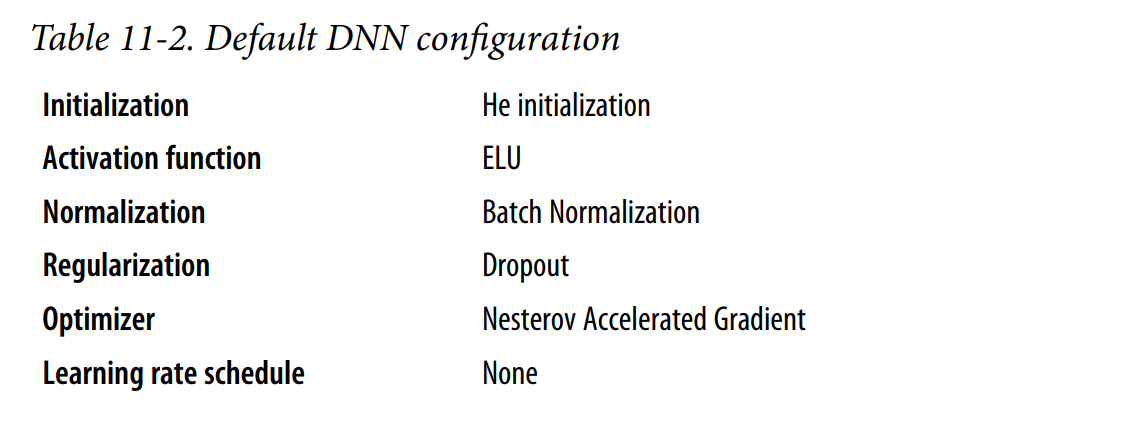